# Face Classification with Random Forests and PCA (Python)

## 1. Introduction

This notebook explores **face classification** using **Random Forest classifiers**, with and without **Principal Component Analysis (PCA)**, based on the **Labeled Faces in the Wild (LFW)** dataset.

The goal is to understand how **dimensionality reduction** affects:
- classification performance,
- training efficiency, and
- feature importance in high-dimensional image data.

To this end, I compare a Random Forest trained directly on raw pixel features
with one trained on PCA-transformed representations. The analysis includes
dataset exploration, stratified train–test splitting, baseline model training,
PCA-based dimensionality reduction (including eigenface visualization),
and a systematic comparison of performance, training time, and feature importance.

The notebook is based on the structure of the original coursework but is
reorganized and refined to emphasize experimental reasoning, trade-offs,
and empirical insights rather than step-by-step task execution.

*Disclaimer*: Some concepts and code patterns are adapted from lecture materials,
lab exercises, and course references, including *Hands-On Machine Learning*
(Géron, 2019).




**Importing the libraries**

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## 2. Dataset and Problem Setup

### 2.1 Dataset Description

The **Labeled Faces in the Wild (LFW)** dataset is a public collection of face images of well-known individuals collected from the internet. It is commonly used for face recognition and multi-class face classification tasks.

In this notebook, I use a filtered version of the dataset provided via `scikit-learn`, with the following settings:
- `min_faces_per_person = 70`: only individuals with at least 70 images are included
- `resize = 0.5`: images are downsampled to reduce dimensionality

In [ ]:
# import dataset
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [ ]:
# dataset descriptiion
# print(lfw_people['DESCR'])

In [ ]:
print("LFW dataset overview:")
print(f"Number of samples: {n_samples}")
print(f"Image size: {h} x {w}")
print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")

LFW dataset overview:
Number of samples: 1288
Image size: 62 x 47
Number of features: 2914
Number of classes: 7


#### (a) Examples

In [ ]:
print("Sample indices in target vector:", np.unique(y))
print("Class names (people):", target_names)
print(f"Total number of face images: {n_samples}")

Sample indices in target vector: [0 1 2 3 4 5 6]
Class names (people): ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total number of face images: 1288


There are 1,288 examples in this filtered version of the dataset. Each example is a single grayscale image of a public figure's face. These images are abeled by the identity of the person.

#### (b) Features

In [ ]:
print(f"Image shape: {h} x {w}")
print(f"Total number of features: {n_features}")
print("Pixel intensity range:", X.min(), "to", X.max())

Image shape: 62 x 47
Total number of features: 2914
Pixel intensity range: 0.0 to 1.0


Each image is 62 x 47 pixels, and it is flattened into a single 1D feature vector of length 2,914.  
Each feature represents the grayscale intensity of one pixel, and it is scaled to float values between 0.0 and 1.0.  
These features are used as the input to machine learning models.

#### (c) Target

In [ ]:
counts = np.bincount(y)

class_df = pd.DataFrame({
    "Class Index": np.arange(len(target_names)),
    "Person": target_names,
    "Sample Count": counts
}).sort_values("Sample Count", ascending=False)
print(class_df[["Person", "Sample Count"]])

              Person  Sample Count
3      George W Bush           530
1       Colin Powell           236
6         Tony Blair           144
2    Donald Rumsfeld           121
4  Gerhard Schroeder           109
0       Ariel Sharon            77
5        Hugo Chavez            71


There are 7 classes in total, each corresponding to a different person. The labels are integers from 0 to 6, and each label maps to a name in `target_names`. The class distribution is imbalanced, and some people have more photos than others.

**Dataset Challenges:**
- Class imbalance: some people (e.g., George W Bush) have far more images than others.
- High dimensionality: 2,914 features and only 1,288 samples.

### 2.2 Train–Test Split with Stratification

The dataset exhibits **class imbalance**, with some individuals (e.g., George W. Bush) having significantly more images than others.

Given the relatively small dataset size (1,288 samples) and uneven class distribution, I use **stratified sampling** to split the data into:
- **80% training set**
- **20% test set**

Stratification ensures that class proportions are preserved in both splits, reducing the risk of sampling bias and enabling fair evaluation.

In [ ]:
class_df["Percentage"] = class_df["Sample Count"] / n_samples * 100
print("\nClass Distribution Percentages:")
print(class_df[["Person", "Sample Count", "Percentage"]])


Class Distribution Percentages:
              Person  Sample Count  Percentage
3      George W Bush           530   41.149068
1       Colin Powell           236   18.322981
6         Tony Blair           144   11.180124
2    Donald Rumsfeld           121    9.394410
4  Gerhard Schroeder           109    8.462733
0       Ariel Sharon            77    5.978261
5        Hugo Chavez            71    5.512422


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Verify training and test datasets:

In [ ]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

print("\nClass distribution in training set:")
train_counts = np.bincount(y_train)
train_percentages = 100 * train_counts / len(y_train)
for i, name in enumerate(target_names):
    print(f"  {name}: {train_counts[i]} samples ({train_percentages[i]:.1f}%)")

print("\nClass distribution in test set:")
test_counts = np.bincount(y_test)
test_percentages = 100 * test_counts / len(y_test)
for i, name in enumerate(target_names):
    print(f"  {name}: {test_counts[i]} samples ({test_percentages[i]:.1f}%)")

Training set size: 1030 samples
Test set size: 258 samples

Class distribution in training set:
  Ariel Sharon: 61 samples (5.9%)
  Colin Powell: 189 samples (18.3%)
  Donald Rumsfeld: 97 samples (9.4%)
  George W Bush: 424 samples (41.2%)
  Gerhard Schroeder: 87 samples (8.4%)
  Hugo Chavez: 57 samples (5.5%)
  Tony Blair: 115 samples (11.2%)

Class distribution in test set:
  Ariel Sharon: 16 samples (6.2%)
  Colin Powell: 47 samples (18.2%)
  Donald Rumsfeld: 24 samples (9.3%)
  George W Bush: 106 samples (41.1%)
  Gerhard Schroeder: 22 samples (8.5%)
  Hugo Chavez: 14 samples (5.4%)
  Tony Blair: 29 samples (11.2%)


The training set contains 1,030 samples and the test set contains 258 samples. Class ratios in both sets closely match the original distribution.

### 2.3 Visual Inspection of Face Images

To better understand the visual characteristics of the dataset, I randomly sample **one training image per class** and display them.

This inspection helps illustrate:
- variations in facial pose, lighting, and expression,
- differences in image quality across individuals,
- and the overall difficulty of the classification task.

The figure below shows one randomly selected training image for each person.

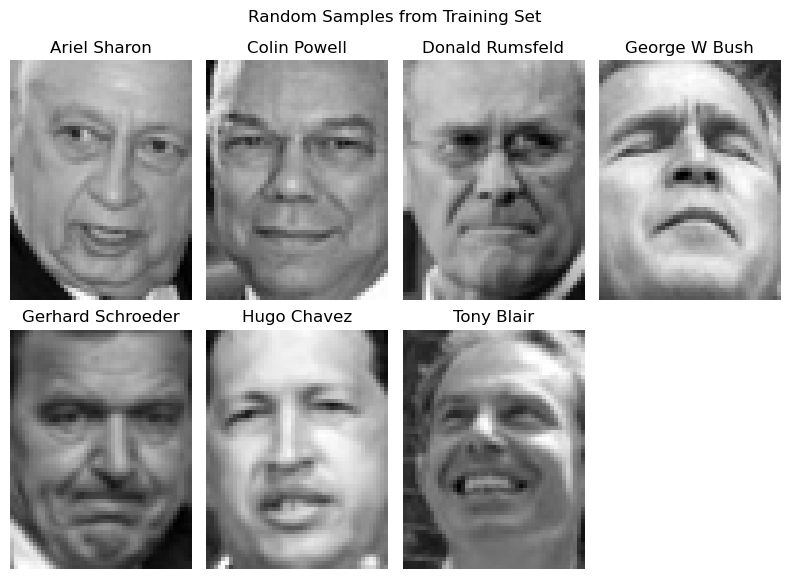

In [ ]:
np.random.seed(42)
plt.figure(figsize=(8, 6))

for i, class_name in enumerate(target_names):
    # get all indices of this class and select a random one
    indices = np.where(y_train == i)[0]
    random_idx = np.random.choice(indices)

    # reshape the random image
    image = X_train[random_idx].reshape(h, w)

    # display image
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Random Samples from Training Set")
plt.tight_layout()
plt.show()

## 3. Random Forest Classification (Baseline)

In this section, I train a Random Forest classifier on the original high-dimensional pixel features and use it as a baseline for comparison with PCA-based models. Random Forests are well suited for high-dimensional data and provide built-in estimates of feature importance, making them a strong baseline for this task.

### 3.1 Evaluation Utilities

To avoid repeating code across experiments, I define several helper functions that are reused throughout this notebook:

- `performance_metrics`: computes accuracy, precision, recall, and F1-score
- `confusion_matrix_plot`: visualizes both raw and normalized confusion matrices
- `plot_feature_importance`: displays feature importance as a heatmap aligned with the original image shape

These utilities are used for evaluating both the baseline model and the PCA-based models in later sections.

In [ ]:
# helper functions

from sklearn.metrics import classification_report

def performance_metrics(y_test, y_pred, target_names=None):
    # print precision, recall, F1-score, and accuracy
    report = classification_report(y_test, y_pred, target_names=target_names,
                                   output_dict=True, zero_division=0 )
    metrics_df = pd.DataFrame(report).T.round(3)
    print(metrics_df)

    accuracy = np.mean(y_pred == y_test)
    print(f"\nOverall accuracy: {accuracy:.3f}")

def confusion_matrix_plot(y_test, y_pred, target_names, title_suffix=""):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=target_names,
        xticks_rotation=90,
        ax=axs[0]
    )
    axs[0].set_title(f"Confusion Matrix {title_suffix}")

    # normalized confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=target_names,
        xticks_rotation=90,
        normalize="true",
        values_format=".0%",
        ax=axs[1]
    )
    axs[1].set_title(f"Normalized CM {title_suffix}")

    plt.tight_layout()
    plt.show()

### 3.2 Random Forest Model and Training

In [ ]:
# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Random Forests**

A Random Forest is an ensemble of decision trees trained using the bagging strategy. Each tree is built on a random subset of the data and features, introducing diversity among trees.

This randomness trades a slight increase in bias for a significant reduction in variance, often leading to better generalization performance.

In this experiment, the model is trained directly on the raw pixel space (2,914 features) and evaluated on the test set. Training and prediction time are also recorded.

Hyperparameters:
- `n_estimators=1000`: 1000 trees (default)  
- `criterion='gini'`: splitting criterion (default)  
- `max_depth=None`: trees expand until leaves are pure or too small to split (default)  
- `min_samples_split=2`: minimum samples to split a node (default)  
- `random_state=42`: for reproducibility

In [ ]:
import time

rf_clf = RandomForestClassifier(
    n_estimators=1000,
    random_state=42
)

%time rf_clf.fit(X_train, y_train)
%time y_pred = rf_clf.predict(X_test)

CPU times: user 16.9 s, sys: 56 ms, total: 17 s
Wall time: 17 s
CPU times: user 39.6 ms, sys: 1.81 ms, total: 41.4 ms
Wall time: 41.4 ms


### 3.3 Performance Evaluation

The model is evaluated using classification metrics and confusion matrices.

In [ ]:
performance_metrics(y_test, y_pred, target_names)

                   precision  recall  f1-score  support
Ariel Sharon           1.000   0.062     0.118   16.000
Colin Powell           0.818   0.766     0.791   47.000
Donald Rumsfeld        1.000   0.333     0.500   24.000
George W Bush          0.578   0.981     0.727  106.000
Gerhard Schroeder      0.857   0.273     0.414   22.000
Hugo Chavez            1.000   0.214     0.353   14.000
Tony Blair             0.667   0.345     0.455   29.000
accuracy               0.651   0.651     0.651    0.651
macro avg              0.846   0.425     0.480  258.000
weighted avg           0.744   0.651     0.602  258.000

Overall accuracy: 0.651


**Error analysis** - confusion matrix

I included both the raw confusion matrix (left) and the normalized version (right) to show not only the total number of correct and incorrect predictions, but also the proportion of errors for each class, which helps compare performance across classes with different sample sizes.

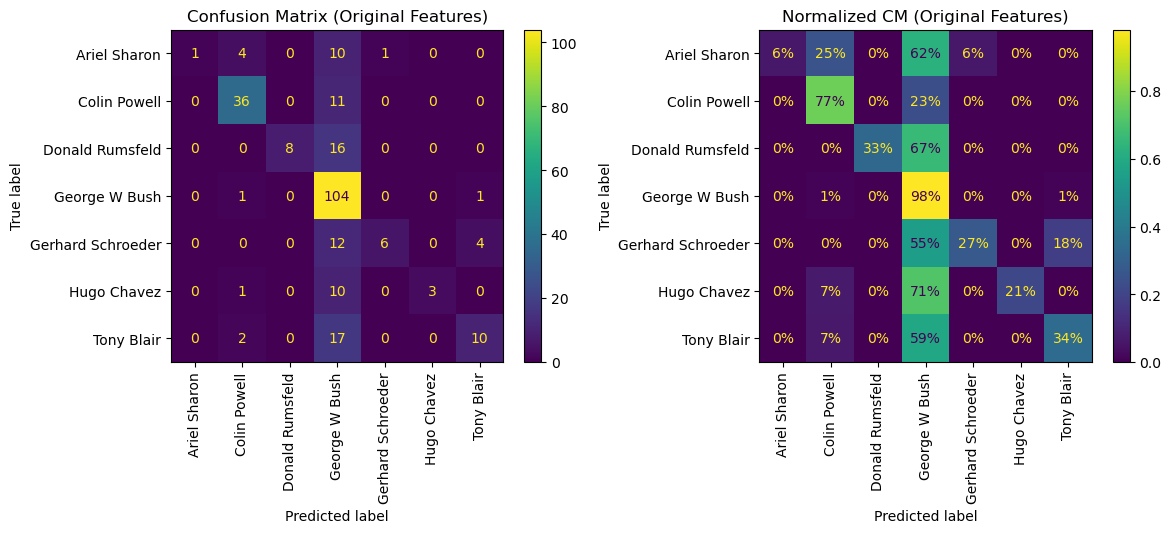

In [ ]:
confusion_matrix_plot(y_test, y_pred, target_names, title_suffix="(Original Features)")

Baseline performance (original features):
- Accuracy: 0.655
- Macro F1-score: 0.480

The results show that the model performs very well on the most frequent class (George W. Bush), achieving high recall. However, recall is substantially lower for minority classes such as Ariel Sharon and Hugo Chavez.

This indicates a strong bias toward the dominant class, which is expected given the class imbalance and high-dimensional input space. These results serve as a baseline for later comparison with PCA-based models.

### 3.4 Feature Importance Analysis

Feature importance can be used to provide overall summary about the contribution of each feature to the trees. For a given feature, the relative feature importance is the average total descrese in the Gini index due to splits using that feature (the rf_clf has deault `criterion='gini'`). Therefore, a large value indicates an important feature.

Access the this via `feature_importances_`.
To make meaningful investigations, I visualize the importance of each pixel:

In [ ]:
# helper function

def plot_feature_importance(importances, h, w, title="Feature Importance Map"):
    # get the importances and reshape it to image size
    importance_img = importances.reshape(h, w)

    # use heatmap to display the importances
    heatmap = plt.imshow(importance_img, cmap="hot")

    cbar = plt.colorbar(heatmap, ticks=[importance_img.min(), importance_img.max()])
    cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=12)

    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

I visualize the important regions the model focuses on:

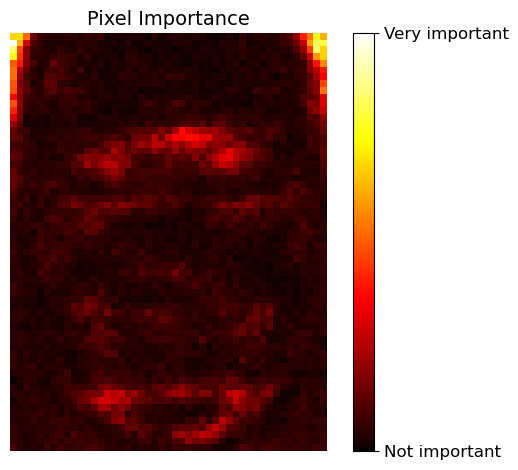

In [ ]:
plot_feature_importance(rf_clf.feature_importances_, h, w,
                        title="Pixel Importance")

Feature Importance Map

- Shows the facial regions most useful for classification
- Brighter areas indicate higher feature importance
- The model focuses mainly on:
  - **Eyes**: key distinguishing features across individuals.
  - **Nose and mouth**: central regions with consistent importance
- Background and peripheral areas are mostly ignored

## 4. Dimensionality Reduction with PCA

High-dimensional image data can be computationally expensive and may contain redundant or noisy features. In this section, I apply Principal Component Analysis (PCA) to reduce the dimensionality of the face images and study its impact on model efficiency and classification performance.


### 4.1 Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a widely used linear dimensionality reduction technique. It identifies orthogonal directions (principal components) that capture the maximum variance in the data, and projects the original features onto a lower-dimensional subspace.

In this notebook, PCA is used to reduce the dimensionality of face images while retaining most of the original variance. Following the assignment specification, I retain 150 principal components.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=150, # 150 principle compoenents
    random_state=42)
pca.fit(X_train)

PCA(n_components=150, random_state=42)

#### 4.1.1 Dimensionality Before and After PCA




In [ ]:
original_dim = X_train.shape[1]
reduced_dim = pca.n_components_

print(f"Original dimensions: {original_dim}")
print(f"Reduced dimensions after PCA: {reduced_dim}")

Original dimensions: 2914
Reduced dimensions after PCA: 150


- Original feature dimension: 2,914 (62 × 47 pixels per image)
- Reduced dimension after PCA: 150

Each face image is projected from the original pixel space into a 150-dimensional latent space, significantly reducing feature dimensionality.

#### 4.1.2 Explained Variance Ratio

In [ ]:
total_explained = pca.explained_variance_ratio_.sum()

print(f"Explained variance ratio (150 PCs): {total_explained:.4f}")

Explained variance ratio (150 PCs): 0.9372


The cumulative explained variance ratio of the 150 retained components is: 93.72%.

This means PCA preserves over 93% of the variance in the original dataset, while discarding approximately 7% of the information. Such dimensionality reduction can substantially speed up training and reduce memory usage, but may also remove discriminative details needed for classification.

#### 4.1.3 Eigenfaces Visualization

The principal components learned by PCA can be reshaped into images known as eigenfaces. Each eigenface represents a direction of maximal variance in the dataset.

The first 10 eigenfaces are visualized to illustrate the dominant patterns captured by PCA.

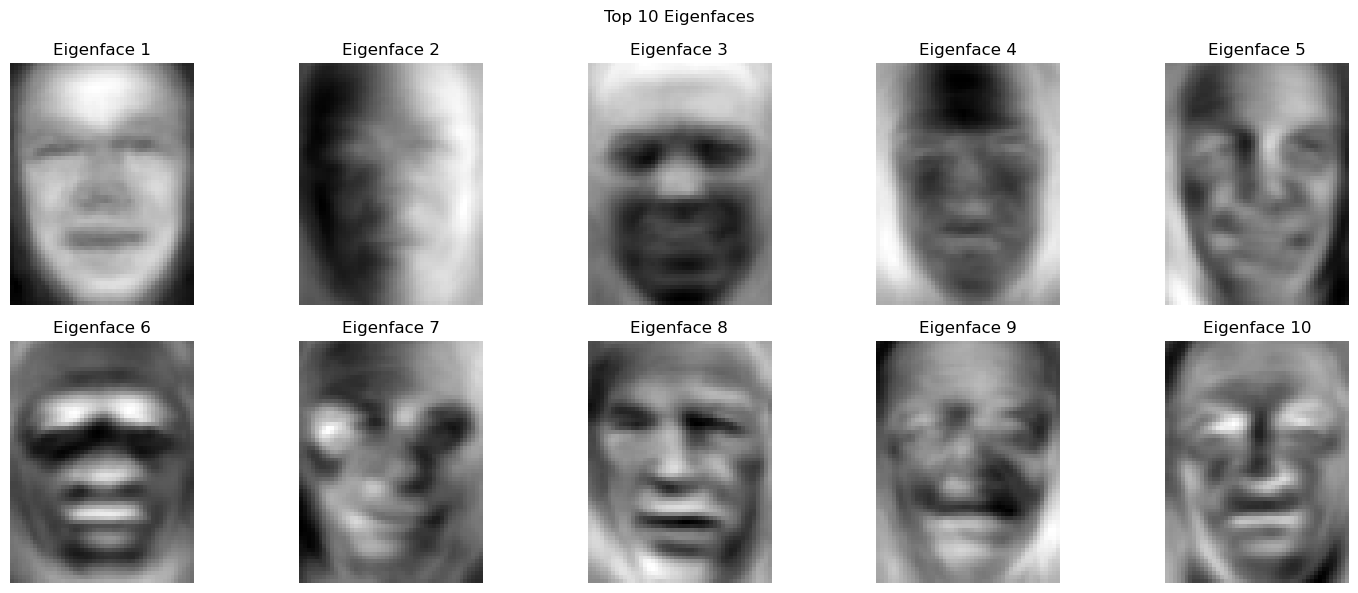

In [ ]:
eigenfaces = pca.components_.reshape((150, h, w))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.suptitle("Top 10 Eigenfaces")
plt.tight_layout()
plt.show()

#### 4.1.4 Interpretation of Eigenfaces
Eigenfaces are not actual faces, but basis patterns that describe how faces vary across the dataset:
- Early components capture global variations, such as lighting and general face structure
- Later components represent finer details, including facial features and textures
- Any original face image can be approximated as a weighted combination of these eigenfaces

Eigenfaces are useful for:
- data compression,
- noise reduction,
- and potentially improving model efficiency in high-dimensional tasks.

### 4.2 Random Forest Classification on PCA-Transformed Data

To evaluate the effect of PCA on classification performance, I train a Random Forest classifier on the PCA-transformed data.

To ensure a fair comparison, the same Random Forest configuration used in the baseline model (Section 3) is applied here.

In [ ]:
# apply PCA transformation
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Use tuned Random Forest on PCA-reduced features
rf_pca_clf = RandomForestClassifier(
    n_estimators=1000,
    random_state=42
)

%time rf_pca_clf.fit(X_train_reduced, y_train)
%time y_pred_pca = rf_pca_clf.predict(X_test_reduced)

CPU times: user 4.95 s, sys: 21 ms, total: 4.98 s
Wall time: 4.98 s
CPU times: user 38 ms, sys: 464 µs, total: 38.5 ms
Wall time: 38.5 ms


                   precision  recall  f1-score  support
Ariel Sharon           0.000   0.000     0.000   16.000
Colin Powell           0.927   0.809     0.864   47.000
Donald Rumsfeld        1.000   0.083     0.154   24.000
George W Bush          0.498   0.981     0.660  106.000
Gerhard Schroeder      1.000   0.045     0.087   22.000
Hugo Chavez            0.000   0.000     0.000   14.000
Tony Blair             0.800   0.138     0.235   29.000
accuracy               0.578   0.578     0.578    0.578
macro avg              0.603   0.294     0.286  258.000
weighted avg           0.642   0.578     0.477  258.000

Overall accuracy: 0.578


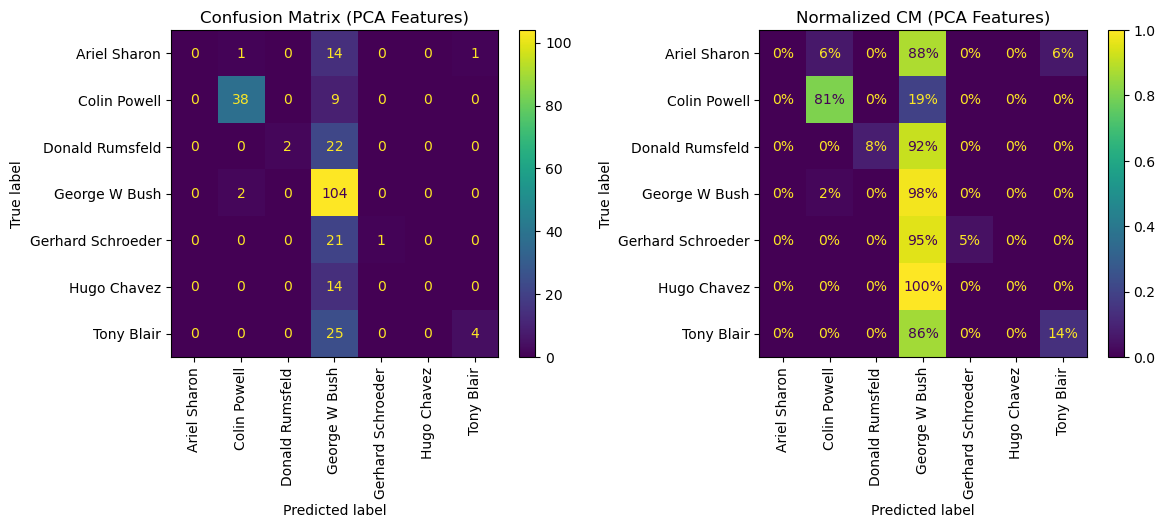

In [ ]:
performance_metrics(y_test, y_pred_pca, target_names)
confusion_matrix_plot(y_test, y_pred_pca, target_names, title_suffix="(PCA Features)")

PCA-transformed features (150 dimensions):
- Accuracy: 0.574
- Macro F1-score: 0.278

Compared to the baseline Random Forest trained on raw pixel features:
- Training and prediction are faster
- Feature dimensionality is greatly reduced
- Overall classification performance decreases significantly

## 5. Results Investigation

In this section, I compare the Random Forest classifiers trained on original pixel features (Section 3) and PCA-transformed features (Section 4). The comparison focuses on classification performance, training efficiency, and feature importance.


#### 5.1 Model Performance Comparison

Original features (2914 dimensions):
- Accuracy: 0.655
- Macro F1-score: 0.480
- Major classes such as George W. Bush (recall = 0.98) and Colin Powell (recall = 0.79) are classified well.
- Minority classes perform poorly, e.g. Ariel Sharon (recall = 0.06) and Hugo Chavez (recall = 0.21).

PCA-transformed features (150 dimensions):
- Accuracy: 0.574
- Macro F1-score: 0.278
- Colin Powell remains relatively strong (recall = 0.81).
- Several minority classes, including Ariel Sharon and Hugo Chavez, are not detected at all (recall = 0.00).

**Interpretation**
PCA preserves over 93.7% of the variance in the original dataset, but the remaining information loss appears to disproportionately affect minority classes. While PCA removes noise and redundancy, it also removes fine-grained, class-specific details that are critical for distinguishing less frequent identities.

This outcome aligns with expectations: dimensionality reduction improves compactness but can reduce discriminative power, especially in imbalanced, multi-class problems.

#### 5.2 Training Time Comparison

Based on timing results:
- Original features
  - Training: 16.9 s
  - Prediction: 40.9 ms
-PCA features
  - Training: 4.84 s
  - Prediction: 37.1 ms

**Observation**
- Training with PCA is approximately 3× faster
- Prediction time is also slightly reduced

**Interpretation**

Reducing dimensionality from 2,914 to 150 significantly lowers the computational cost of evaluating splits in Random Forests. This confirms that PCA greatly improves training efficiency, at the expense of classification performance.

#### 5.3 Feature Importance and PCA Reconstruction

Feature importance analysis reveals distinct differences between the two models.

In [ ]:
# reconstruct PCA importances to original space
importances_pca = rf_pca_clf.feature_importances_  # shape: (150,)
importances_reconstructed = np.dot(importances_pca, pca.components_)  # shape: (2914,)

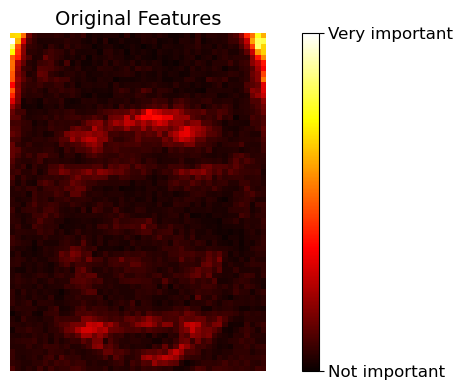

In [ ]:
plt.figure(figsize=(8, 4))

plot_feature_importance(rf_clf.feature_importances_, h, w,
                        title="Original Features")

Feature importance is relatively sparse.
- A few small regions (e.g., around eyes and nose) show up as high-importance, but the pattern is noisy and fragmented.
- The model likely relies on scattered pixel-level cues, which may be harder to generalize.

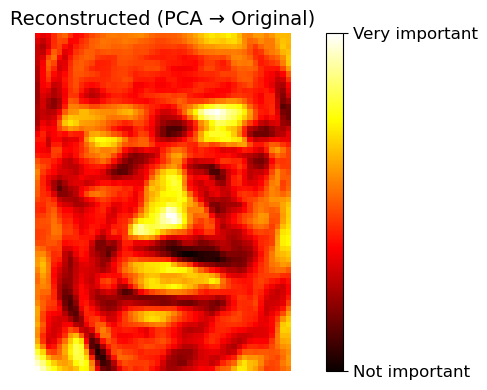

In [ ]:
plt.figure(figsize=(8, 4))
plot_feature_importance(importances_reconstructed, h, w,
                        title="Reconstructed (PCA → Original)")

After training the Random Forest on PCA-reduced data, I projected the feature importances back into the original pixel space.
- The result shows a clearer facial structure — with emphasis on meaningful regions like the eyes, eyebrows, nose, and mouth.
- This indicates that PCA helped extract more coherent, global features

PCA helped the model focus on structured, discriminative areas rather than isolated pixels. Reconstructed importance offers more interpretable insights into which parts of the face were useful for prediction.

This aligns with my expectations: PCA reduces noise and emphasizes variance.

#### 5.4 PCA Image Reconstruction

To further understand what information PCA preserves, I compare original images with their PCA reconstructions (150 components):
- Top row: original grayscale images
- Bottom row: PCA-reconstructed images

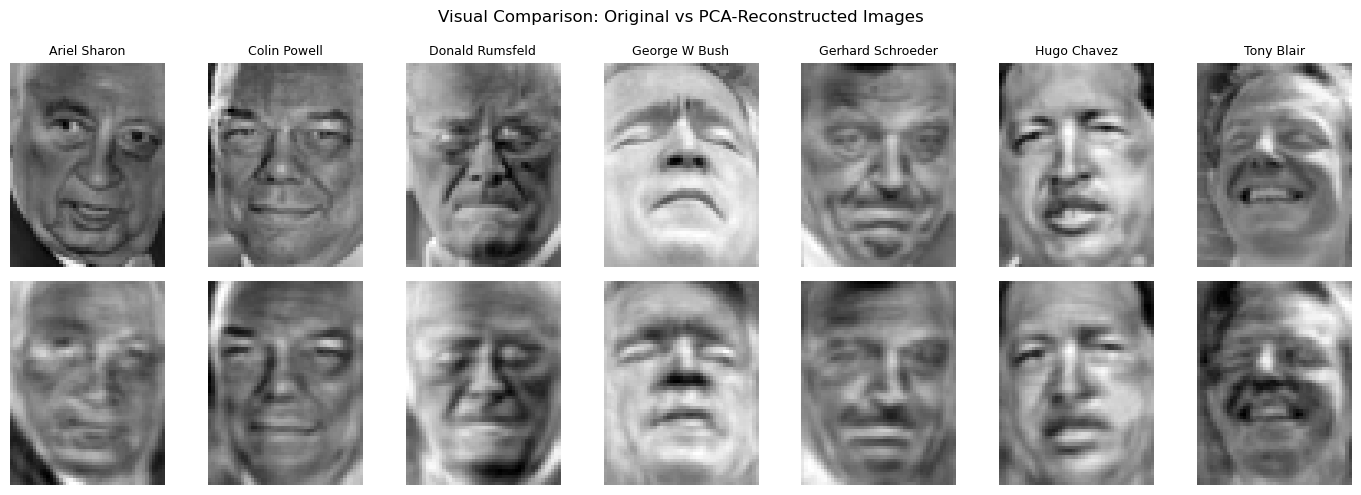

In [ ]:
# Random sample per class from training set
np.random.seed(42)
fig, axs = plt.subplots(2, 7, figsize=(14, 5))  # 2 rows: original & recon

for i, class_name in enumerate(target_names):
    # Get random index for each class
    indices = np.where(y_train == i)[0]
    rand_idx = np.random.choice(indices)

    # Original and reconstructed image
    original = X_train[rand_idx].reshape(h, w)
    recon = pca.inverse_transform(X_train_reduced)[rand_idx].reshape(h, w)

    # Row 1: Original
    axs[0, i].imshow(original, cmap='gray')
    axs[0, i].set_title(class_name, fontsize=9)
    axs[0, i].axis('off')

    # Row 2: Reconstructed
    axs[1, i].imshow(recon, cmap='gray')
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", fontsize=10)
axs[1, 0].set_ylabel("PCA Recon.", fontsize=10)
plt.suptitle("Visual Comparison: Original vs PCA-Reconstructed Images", fontsize=12)
plt.tight_layout()
plt.show()

Although the reconstructed images are blurrier, key facial structures such as head shape and eye regions remain recognizable. This visual result is consistent with PCA’s high explained variance and helps explain why PCA-based classification remains reasonable despite reduced accuracy.

**Overall Summary**

PCA introduces a clear trade-off:
- Pros: faster training, lower dimensionality, improved interpretability
- Cons: reduced classification performance, especially for minority classes

In this task, PCA improves efficiency but weakens the model’s ability to distinguish fine-grained identity differences, highlighting the importance of balancing efficiency and discriminative power in high-dimensional image classification.

## 6. Conclusion

This work goes beyond implementing models and focuses on understanding how and why they behave as they do.

Through face classification with Random Forests, both with and without PCA, I explored the trade-offs between model performance, efficiency, and interpretability. PCA significantly reduces dimensionality (from 2,914 to 150) and speeds up training, but at the cost of reduced recall for minority classes. Visual analysis using eigenfaces and reconstructed feature importance helps explain how dimensionality reduction alters what the model learns.

Overall, the experiments highlight that while PCA is valuable for improving efficiency and interpretability in high-dimensional image data, it may weaken class-specific discrimination in imbalanced settings. Choosing whether to apply dimensionality reduction therefore depends on the task’s priorities—efficiency versus predictive sensitivity.


This assignment is not just about coding models — it is about understanding how and why they work.

explores face classification with Random Forest and PCA. I compare models with and without PCA to understand the trade-offs. PCA speeds up training and reduces dimensionality from 2914 to 150, but results in lower recall on rare classes. Visualizations of eigenfaces and feature importance help explain how PCA impacts what the model learns.

Each part follows a clear question and the experiments help me see both the strengths and the limits of these methods.


## 7. Reference
- Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (2nd ed.). O’Reilly Media.
- Dua, D., & Graff, C. (2019). *UCI Machine Learning Repository*. University of California, Irvine, School of Information and Computer Sciences. https://doi.org/10.24432/C5DW2B
- Scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html